## Исследование данных о российском кинопрокате



Целью проекта является изучение рынка российского кинопроката, выявление текущих трендов, изучение эффективности  государственной поддержки отдельных фильмов и режиссеров, зрительского интереса к таким фильмам на основе открытых данных Министерства культуры, а также а также информации с сайта КиноПоиск.
Для начала мы изучим датасет, проведем предобработку данных - установим наличие пропущенных значений и заменим их на логически подходящие, при необходимости изменим тип данных, проверим наличие дубликатов. Изучим столбцы с категориальными и количественными переменными, при наличии проблемных моментов, препятствующих анализу, их устраним. Далее, в соответствии с условиями задачи  создадим столбцы с информацией о годе проката, именеми и фамилии главного режиссёра, основного жанра фильма. В ходе исследовательского анализа посчитаем  количество фильмов, выходивших в каждый год, долю фильмов, в отношении которых есть информация о прокате в кинотеатрах от общего количества вышедших, в том числе изменение этой доли по годам. Изучим  динамику проката и сумму сборов от них по годам. С помощью сводной таблицы посчитаем среднюю и медианную сумму сборов для каждого года. Проведем отдельное исследование влияния возрастного ограничения аудитории на сборы фильма в прокате в период с 2015 по 2019 год, изменение этой картины в зависимости от года.
Отдельно исследуем фильмы, получившие государственную поддержку. Установим преимущественные значения таких параметров как возрастная ориентированность этих фильмов, тип, жанр. Уделим внимание фильмам, которые, сборы от проката которых превысили бюджет. Для исследования построим графики, выведем процент корреляции исследуемых параметров. 

### Шаг 1. Чтение  файлов с данными, объединение в один датафрейм. 

In [19]:
import pandas as pd

In [20]:
data_movies = pd.read_csv('C:/Users/User/Downloads/mkrf_movies.csv')
print(data_movies.head())
data_movies.info()

                  title   puNumber           show_start_date            type  \
0      Открытый простор  221048915  2015-11-27T12:00:00.000Z  Художественный   
1  Особо важное задание  111013716  2016-09-13T12:00:00.000Z  Художественный   
2          Особо опасен  221038416  2016-10-10T12:00:00.000Z  Художественный   
3          Особо опасен  221026916  2016-06-10T12:00:00.000Z  Художественный   
4          Особо опасен  221030815  2015-07-29T12:00:00.000Z  Художественный   

                                         film_studio production_country  \
0  Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...                США   
1                              Киностудия "Мосфильм"               СССР   
2  Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...                США   
3  Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...                США   
4  Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...                США   

            director                                           produ

In [21]:
data_shows = pd.read_csv('C:/Users/User/Downloads/mkrf_shows.csv')
print(data_shows.head())
data_shows.info()

    puNumber    box_office
0  111000113  2.450000e+03
1  111000115  6.104000e+04
2  111000116  1.530300e+08
3  111000117  1.226096e+07
4  111000118  1.636841e+08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


По условию проекта нам необходимо объединить датафреймы data_movies и data_shows.Для объединения используем метод merge() по столбцу 'puNumber' с параметром how='left'. Чтоб все строки из data_movies вошли в объединенный датафрейм, его и возьмем в качестве левого датафрейма. Новому датафрейму присвоим наименование data. Прежде чем приступить к объединению исследуем столбцы 'puNumber' в обоих датафреймах и при наличии данных, препятствующих их объединению,устраним.

In [22]:
data_movies['puNumber'].sort_values().unique()

array([' 111004112', '111000110', '111000111', ..., '231001012',
       '231001111', 'нет'], dtype=object)

В столбце 'puNumber' датафрейма data_movies в первом значении имеется пропуск, последнее значение, поименованное как 'нет', является аномальным. Для перевода первого значения в формат, пригодный для анализа, применим метод str.strip(), который уберет лишний пропуск. Аномальное значение 'нет' устраним, задав условие в data_movies puNumber != "нет" со сменой индексации посредством метода reset_index(drop=True). Также приведем данные этого столбца к типу 'int', поскольку в аналогичном столбце data_shows именно такой тип данных.

In [23]:
data_movies['puNumber'] = data_movies['puNumber'].str.strip()
data_movies = data_movies.query('puNumber != "нет"').reset_index(drop=True)
data_movies['puNumber'] = data_movies['puNumber'].astype('int') 
data_movies['puNumber'].sort_values().unique()

array([  1811096, 111000110, 111000111, ..., 226019110, 231001012,
       231001111])

Аномальные значения в столбце 'puNumber' датафрейма data_movies устранены. Теперь проверим этот столбец в data_shows.

In [24]:
data_shows['puNumber'].sort_values().unique()

array([111000113, 111000115, 111000116, ..., 224022410, 224023210,
       224026410], dtype=int64)

Теперь можно приступить к объединению. Новому датафрейму присвоим имя data и сразу переведем наименование столбца с номером прокатного удостоверения к единому стилю.

In [25]:
data = data_movies.merge(data_shows, on='puNumber', how='left')
data = data.rename(columns = {'puNumber':'punumber'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7485 non-null   object 
 1   punumber               7485 non-null   int32  
 2   show_start_date        7485 non-null   object 
 3   type                   7485 non-null   object 
 4   film_studio            7467 non-null   object 
 5   production_country     7483 non-null   object 
 6   director               7476 non-null   object 
 7   producer               6917 non-null   object 
 8   age_restriction        7485 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

Датафреймы объединены, все объекты из data_movies (за исключением строки с аномальным значением, которую мы удалили) вошли в новый датафрейм, наименование столбца, по которому произошло объединение, приведено к общепринятому стилю. Теперь приступим к предобработке данных.

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверяем типы данных



Проверяем типы данных в объединенном датафрейме data. В результате работы над объединением датафреймов в столбце 'puNumber' данные приведены к типу 'int'.В столбце 'show_start_date' тип данных о дате объявления сохранены как object. Методом astype() переводим их в тип datetime.

In [26]:
data['show_start_date'] = data['show_start_date'].astype('datetime64')
print(data['show_start_date'])

0      2015-11-27 12:00:00
1      2016-09-13 12:00:00
2      2016-10-10 12:00:00
3      2016-06-10 12:00:00
4      2015-07-29 12:00:00
               ...        
7480   2019-12-23 12:00:00
7481   2019-12-24 12:00:00
7482   2019-12-28 12:00:00
7483   2019-12-30 12:00:00
7484   2019-12-30 12:00:00
Name: show_start_date, Length: 7485, dtype: datetime64[ns]


В столбцах 'refundable_support', 'nonrefundable_support'тип данных 'float64'. В столбце 'box_office' тип данных о выручке показан в рублях как 'float' с высокой степенью разрядности. Для удобства анализа 'float' переведем в цельночисленный тип. Но перед этим заполним пропуски методом fillna() значением 0, поскольку в столбцах 'refundable_support', 'nonrefundable_support' они скорее всего означают отсутствие государственного софинансирования. Пропуски в 'box_office' могут свидетельствовать либо об отсутствии сборов, либо отсутствии информации о прокате. Чтобы они не препятствовали анализу, также заменим их нулевыми значениями. При необходимости будем задавать условие box_office != 0.

In [27]:
data['refundable_support'] = data['refundable_support'].fillna(0).astype('int')
data['nonrefundable_support'] = data['nonrefundable_support'].fillna(0).astype('int')
data['box_office'] = data['box_office'].fillna(0).astype('int')

#### Шаг 2.2. Изучение пропусков в датафрейме


Изначально в датафрейме data имелись пропуски в столбцах 'refundable_support', 'nonrefundable_support', 'box_office', которые мы заменили нулевыми значениями при унификации типов данных. Для проверки наличия пропусков по другим столбцам вызовем метод isna().sum().

In [28]:
data.isna().sum()

title                       0
punumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support          0
nonrefundable_support       0
budget                   7153
financing_source         7153
ratings                   966
genres                    975
box_office                  0
dtype: int64

В столбце 'financing_source' имеется 7153 пропуска. Это также может означать, что фильм не имел государственного финансирования. Для удобства работы с базой данных заменим их на 'unknown'.

In [29]:
data['financing_source'] = data['financing_source'].fillna('unknown')
data['financing_source'].value_counts()

unknown                             7153
Министерство культуры                164
Фонд кино                            146
Министерство культуры, Фонд кино      22
Name: financing_source, dtype: int64

В столбце 'genres' имеется 975 пропусков. Вполне возможно что при внесении информации о жанре этих фильмов при его определении возникли затруднения. Также заменим их на 'unknown'.

In [30]:
data['genres'] = data['genres'].fillna('unknown')

В столбце 'director' имеется 9 пропусков, связанные скорее всего с "человеческим фактором". И их заменим на 'unknown'.

In [31]:
data['director'] = data['director'].fillna('unknown')

 В столбце 'ratings' 966 пропусков, которые мы не можем ни проигнорировать, так как этот показатель является предметом анализа, ни удалить, так как их количество более 10%. Наиболее оптимальным представляется заменить эти пропуски медианным значением. Поскольку данные о рейтинге частично записаны в виде десятичной дроби от 1.0 до 10.0 (float), частичного - в виде строки, представляющей из себя целое число с %, приведем их сначала к единому типу. В тех строках, где содержиться знак %, рассмотрим его как часть строки и используем метод replace() для его замены, задав тот же самый тип, что и в остальных строках float. После этого напишем функцию, которая увеличит разрядность десятичных дробей все значения которых < 10 до целых чисел. Когда все значения станут единообразными, найдем по столбцу 'ratings' медиану и методом fillna() заполним ею пропуски.Все показатели по этому столбцу приведем к цельночисленному типу.

In [32]:
data['ratings'].sort_values().unique()

array(['1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8',
       '1.9', '19%', '2.1', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9',
       '28%', '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7',
       '3.8', '3.9', '4.0', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6',
       '4.7', '4.8', '4.9', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5',
       '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4',
       '6.5', '6.6', '6.7', '6.8', '6.9', '62%', '64%', '7.0', '7.1',
       '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '79%',
       '8.0', '8.1', '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '8.8',
       '8.9', '83%', '88%', '89%', '9.0', '9.1', '9.2', '90%', '91%',
       '94%', '97%', '98%', '99%', nan], dtype=object)

In [33]:
data['ratings'] = data['ratings'].str.replace('%', '').astype('float')
def n (ratings):
    if ratings < 10:
        return ratings * 10 
data['ratings'] = data['ratings'].apply(n)  

Заменяем пропуски на нулевые значения.

In [35]:
data['ratings'] = data['ratings'].fillna(0)
data['ratings'] = data['ratings'].astype('int')
data['ratings'].sort_values().unique()

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92])

В столбцх 'film_studio', 'production_country', 'producer' также имеются пропуски, которые мы оставим в исходном состоянии, поскольку для анализа в соответствии с условием проекта они не имеют значения. И еще раз проверим фактическое устранение всех пропусков в соответствии с написанными кодами.

In [36]:
data.isna().sum()

title                       0
punumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    0
producer                  568
age_restriction             0
refundable_support          0
nonrefundable_support       0
budget                   7153
financing_source            0
ratings                     0
genres                      0
box_office                  0
dtype: int64

#### Шаг 2.3. Поиск и устранение дубликатов


Наличие явных дубликатов проверим методом duplicated().sum().

In [37]:
data.duplicated().sum()

0

Таковых не имеется. Теперь проверим наличие неявнях дубликатов методом sort_values().unique().

In [38]:
data['type'].sort_values().unique()

array([' Анимационный', ' Художественный', 'Анимационный',
       'Документальный', 'Музыкально-развлекательный',
       'Научно-популярный', 'Прочие', 'Художественный'], dtype=object)

В столбце 'type' найдены дубликаты: наименования 'Анимационный' и 'Художественный' указаны с пропусками ' Анимационный' и ' Художественный'. От них мы, в соответствии со структурой проекта, избавимся при выполнении пункта 2.4.

In [39]:
data['production_country'].sort_values().unique()

array([' СССР', ' СССР ', ' СССР   ', '2019', 'CША', 'Австралия',
       'Австралия - Великобритания - Бельгия - Индия',
       'Австралия - Германия', 'Австралия - Ирландия',
       'Австралия - Колумбия', 'Австралия - США', 'Австралия, Канада',
       'Австралия, США', 'Австралия-Великобритания', 'Австралия-Ирландия',
       'Австралия-США', 'Австралия-Турция-США', 'Австрия',
       'Австрия - Германия', 'Австрия - Германия - Франция',
       'Австрия - Люксембург', 'Австрия, Великобритания, Германия',
       'Австрия-Германия-Франция', 'Австрия-Франция-Германия',
       'Азербайджан-Россия', 'Аргентина', 'Аргентина - Бразилия',
       'Аргентина - Испания', 'Аргентина - Испания - Уругвай',
       'Аргентина - Мексика - Бразилия - Франция - США',
       'Аргентина - Уругвай - Россия - Германия - Франция - Нидерланды',
       'Аргентина - Франция - Испания', 'Аргентина, Испания',
       'Аргентина-Испания', 'Армения', 'Армения - Германия',
       'Армения - Казахстан', 'Армения-Россия

В столбце 'production_country' также имеются неявные дубликаты: наименование 'СССР' с пропусками типа 'СССР ', 'СССР ', 'СССР ', 'СССР '; 'США' и 'США '; различное написание одних и тех же стран: 'США - Южная Корея' и 'США- Ю.Корея'. Однако, данные этого столбца в анализе не участвуют, в связи с чем от них избавляться не будем.

Методом value_counts() проверяем наличие дубликатов в столбце 'punumber'.

In [40]:
data['punumber'].value_counts()

221054410    2
221154310    2
122001411    1
111008518    1
114002716    1
            ..
221015415    1
121021814    1
224028210    1
121013618    1
126002916    1
Name: punumber, Length: 7483, dtype: int64

В этом столбце имеются дубликаты номеров "221054410" и "221154310", для удаления которых применяем метод drop_duplicates() с заменой индексации методом reset_index(drop=True) и еще раз проверяем фактическое их устранение.

In [41]:
data['punumber'] = data['punumber'].drop_duplicates().reset_index(drop=True)
data['punumber'].value_counts()

111013418.0    1
121007713.0    1
217000510.0    1
121019317.0    1
121011319.0    1
              ..
121008815.0    1
124010519.0    1
124001812.0    1
112000515.0    1
221164010.0    1
Name: punumber, Length: 7483, dtype: int64

Дубликаты в столбце data['punumber'] устранены. Теперь проверяем дубликаты в столбце 'title' методом duplicated().sum().

In [42]:
print ('Дубликатов в столбце:', data['title'].duplicated().sum())

Дубликатов в столбце: 714


Как мы установили, в данном столбце 714 дубликатов. Речь идет о наименованиях фильмов. Данные дубликаты могли появиться в связи с тем, что прокатные удостоверения на прокат одного и того же фильма могли выдаваться разным юридическим и физическим (индивидуальным предпринимателям) лицам, обладающим исключительным правом на использование фильма, лицензиатам, получившим право на воспроизведение фильма, его распространение, публичный показ, сообщение по кабелю по лицензионному договору. Иными словами, на одно произведение теоретически и практически по закону может быть выдано несколько прокатных удостоверений. Установленное нами количество дубликатов наименований фильмов 714 на 7483 прокатных удостоверения похоже на реальность. Поскольку нам предстоит исследовать такие параметры как количество прокатов, сумму сборов, которые имели место от каждого проката, удалять их не будем. Повторяющиеся наименования фильмов анализу не помешают.

#### Шаг 2.4. Изучение категориальных значений


Методом sort_values().unique() изучаем данные столбцов 'film_studio', 'production_country', 'director', 'producer'.

In [43]:
data['film_studio'].sort_values().unique()
data['production_country'].sort_values().unique()
data['director'].sort_values().unique()
data['producer'].sort_values().unique()

array([' А.Шальопа', ' Г.Шпригов',
       ' Дитмар Ганше, Филипп Фогес,  Бенджамин Херрман, Миша Хоффманн, Эберхард Юнексдорф, Энн Мередит',
       ..., 'Яэль Бергман, Лаура Уотерс, Питер Хеллайар',
       'Яэль Фогель, Летиция Гонзалез', nan], dtype=object)

Изучением этих столбцов установлено, что почти во всех наименования значений написаны с пропусками. В столбце 'puNumber' мы избавились от них применив метод str.strip(). Такие же пропуски имеются в наименованиях начений по столбцам 'film_studio', 'production_country', 'director', 'producer', 'type'. За исключением столбца 'type', в других случаях от этих пропусков избавляться не станем, так как они не окажут влияния на анализ. Кроме того, имеется аномальное значение в столбце 'production_country' - вместо наменования страны указано значение '2019', от которого мы также избавляться не станем, поскольку на процесс анализа оно не повлияет. От аномального значения 'нет' в столбце 'puNumber' мы избавились при объединении датафреймов.

Заменяем дубликаты в столбце 'type' путем устранения пропусков в наименованиях ' Анимационный' и ' Художественный' методом str.strip() и контролируем их устранение.

In [44]:
data['type'] = data['type'].str.strip()
data['type'].value_counts()

Художественный                5908
Анимационный                   829
Прочие                         406
Документальный                 288
Научно-популярный               53
Музыкально-развлекательный       1
Name: type, dtype: int64

Также в столбцах, имеющих категориальные переменные имелись пропущенные значения. В столбцах 'financing_source', 'genres', 'director' мы заменили пропуски на 'unknown'. В столбце 'ratings' пропуски заменили на медианные значения и все данные привели к цельночисленному типу.

В столбце 'show_start_date' тип данных о дате объявления из типа 'object' перевели в тип 'datetime'.

Данные столбца 'ratings' переведены в единообразный формат - проценты в цельночисленном выражении при заполнении пропусков (шаг 2.2 задания).

#### Шаг 2.5. Проверка количественных значений



В столбцах 'refundable_support', 'nonrefundable_support', 'budget' одинаковое количество значений. При переводе данных столбцов 'refundable_support' и 'nonrefundable_support' в 'int' мы заполнили пропуски нулевыми значениями, поскольку, как это пояснялось выше пропуски, скорее всего означают отсутствие финансового государственного участия и, в этой связи, отсутствие в необходимости в государственном контроле общего бюджета таких фильмов. В столбце 'box_office' также имелись пропуски, которые мы заполнили нулевыми значениями.

Проверим, не превышает ли где-то сумма государственной поддержки бюджет фильма, по предложенной формуле. А заодно изучим информацию о них и посчитаем.

In [45]:
display(data[data['budget'] < data['refundable_support'] + data['nonrefundable_support']])
(data[data['budget'] < data['refundable_support'] + data['nonrefundable_support']]).count()

,title,punumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2052,14+,111023614.0,2014-12-19 12:00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",«16+» - для детей старше 16 лет,0,23000000,0.0,"Министерство культуры, Фонд кино",66,мелодрама,10234016
2057,Дуxless 2,111000415.0,2015-01-26 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0,75000000,0.0,Фонд кино,66,драма,446163511
2471,Воин (2015),111017315.0,2015-09-28 12:00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,10000000,70000000,0.0,Фонд кино,78,"боевик,драма,криминал",196572438
2531,Бармен.,111009615.0,2015-05-26 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«16+» - для детей старше 16 лет,20000000,0,0.0,Фонд кино,62,"комедия,фэнтези",67418974
2614,Савва. Сердце воина,114001715.0,2015-07-21 12:00:00,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,«6+» - для детей старше 6 лет,60000000,100000000,0.0,Фонд кино,46,"мультфильм,приключения,фэнтези",184487551
2683,Тряпичный союз,111010215.0,2015-06-08 12:00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«18+» - запрещено для детей,0,59000000,0.0,Фонд кино,63,"комедия,драма",1957738
2787,Срочно выйду замуж,111017115.0,2015-09-30 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,0,35000000,0.0,Фонд кино,51,"комедия,мелодрама",72937783
2873,Помню - не помню!,111004916.0,2016-03-01 12:00:00,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",«12+» - для детей старше 12 лет,0,6000000,0.0,Министерство культуры,43,комедия,15362931
3046,Любовь с ограничениями,111008216.0,2016-04-29 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,19000000,51000000,0.0,Фонд кино,63,"комедия,мелодрама",70299052
3564,Притяжение (2016),111018116.0,2016-12-16 12:00:00,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,0,250000000,0.0,Фонд кино,56,фантастика,1038321489


title                    17
punumber                 17
show_start_date          17
type                     17
film_studio              17
production_country       17
director                 17
producer                 17
age_restriction          17
refundable_support       17
nonrefundable_support    17
budget                   17
financing_source         17
ratings                  17
genres                   17
box_office               17
dtype: int64

Фильмы, где данные столбца 'budget' меньше суммарной величины столбцов 'refundable_support' и'nonrefundable_support' - это те 17 фильмов с нулевым бюджетом, по которым мы задавали условие 'budget != 0' при подсчете доли государственной поддержки и анализе окупаемости. При подсчете доли государственной поддержки от общего бюджета фильма я исходила из того, что в данных о сумме бюджета фильма содержатся суммы возвратных и невозвратных средств государственной поддержки. Сожалею, что при этом дала не совсем понятный комментарий. По поводу нулевых значений в бюджете фильмов с господдержкой: высока вероятность, что это так называемый человеческий фактор - вносивший информацию о бюджете мог решить что необходимо указывать иные средства (не государственные), поскольку государственные уже указаны. Но это предположение, в связи с чем я не стала заменять эти 0 суммой возвратных и невозвратных средств, а ввиду малого количества таких фильмов исключала информацию о них из кода.

После проведения предобработки данных еще раз проверяем наличие дубликатов.

In [46]:
data.duplicated().sum()

0

#### Шаг 2.6. Добавление новых столбцов





 С помощью метода dt.year создаем столбец 'year' в котором сохраняем год проката.

In [47]:
data['year'] = data.loc[:, 'show_start_date'].dt.year
print(data['year'])

0       2015
1       2016
2       2016
3       2016
4       2015
        ... 
7480    2019
7481    2019
7482    2019
7483    2019
7484    2019
Name: year, Length: 7485, dtype: int64


- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

Для создания столбцов с именем и фамилией главного режиссёра и основным жанром фильма применим метод split(), в коотором ',' укажем в качестве разделителя.

In [49]:
def a_g(genres):    
    elem = genres.split(',') 
    return elem[0] 
data['genres_n'] = data['genres'].apply(a_g)
data['director_n'] = data['director'].apply(a_g)#
print(data['genres_n'])
print(data['director_n'])

0           боевик
1            драма
2       фантастика
3       фантастика
4       фантастика
           ...    
7480       unknown
7481        боевик
7482       unknown
7483       unknown
7484       комедия
Name: genres_n, Length: 7485, dtype: object
0           Кевин Костнер
1               Е.Матвеев
2       Тимур Бекмамбетов
3       Тимур Бекмамбетов
4       Тимур Бекмамбетов
              ...        
7480          Фил Грабски
7481           Ник Пауэлл
7482     Чарльз Е.Бастьен
7483             А.Беляев
7484             И.Трусов
Name: director_n, Length: 7485, dtype: object


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7485 non-null   object        
 1   punumber               7483 non-null   float64       
 2   show_start_date        7485 non-null   datetime64[ns]
 3   type                   7485 non-null   object        
 4   film_studio            7467 non-null   object        
 5   production_country     7483 non-null   object        
 6   director               7485 non-null   object        
 7   producer               6917 non-null   object        
 8   age_restriction        7485 non-null   object        
 9   refundable_support     7485 non-null   int32         
 10  nonrefundable_support  7485 non-null   int32         
 11  budget                 332 non-null    float64       
 12  financing_source       7485 non-null   object        
 13  rat

Нам необходимо посчитать долю государственной поддержки от общего бюджета фильма. Будем исходить из того, что государственная поддержка состоит из возвратных средств (данные столбца 'refundable_support') и невозвратных средств (данные столбца 'nonrefundable_support'), которые мы просуммируем по всему датафрейму в каждом из столбцов и сложим вместе. В исходном датафрейме количество заполненных строк по указанным столбцам соответствовало количеству заполненных строк столбца 'budget', из чего можно сделать вывод, что данные об общем бюджете фильма учитываются государством только приналичии государственного софинансирования. По этому чтоб посчитать долю государственной поддержки в общем бюджете фильма, полученную сумму государственной поддержки разделим на сумму всех бюджетных средств. Для этих вычислений создадим датафрейм c условием financing_source != "unknown", который сохраним в переменной s_s.

In [51]:
s_s = data.query('financing_source != "unknown"').reset_index(drop=True)
s_s['budget'].sort_values()

48     0.000000e+00
171    0.000000e+00
91     0.000000e+00
16     0.000000e+00
15     0.000000e+00
           ...     
312    7.799420e+08
329    9.440000e+08
327    9.800000e+08
186    1.032906e+09
307    2.305074e+09
Name: budget, Length: 332, dtype: float64

Изучение данных в новом датафрейме s_s показало, что не по всем фильмам, получившим государственную поддержку имеются сведения об общем бюджете. В этой связи посчитаем их количество и в зависимости от результата определим как с этими данными поступить.

In [52]:
s_s.query('budget == 0')['budget'].count()

17

Таких фильмов всего 17. Представляется правильным для более корректного вычисления доли государственной поддержки от них избавиться, задав дополнительное условие по датафрейму s_s 'budget' != 0.

In [53]:
s_s.query('budget != 0').reset_index(drop=True)
round(((s_s['refundable_support'].sum()+s_s['nonrefundable_support'].sum())/s_s['budget'].sum()*100),1)
print('Доля государственной поддержки от общего бюджета фильма составляет',round(((s_s['refundable_support'].sum(
)+s_s['nonrefundable_support'].sum())/s_s['budget'].sum()*100),1),'%.')

Доля государственной поддержки от общего бюджета фильма составляет 47.8 %.


В ходе анализа фильмов, получивших государственную поддержку, планируется создание отдельного столбца с данными о доле государственной поддержки.

### Вывод:

Прежде, чем приступить к предварительной обработке данных мы объединили два исходных датафрейма, наименование столбца, по которому провели объединение, привели к общепринятому стилю. В ходе предобработки мы проделали следующее. Изменили тип данных в столбцах 'refundable_support', 'nonrefundable_support', 'box_office', 'ratings' на цельночисленный, в столбце 'show_start_date' - на 'datetime64'. В столбцах 'financing_source', 'director' и 'genres' пропущенные значения заменили на 'unknown', в столбцах 'refundable_support', 'nonrefundable_support', 'box_office' - на нулевые значения, в столбце 'ratings' - на медианные. Проверили наличие явных и неявных дубликатов. Ибавились от неявных дубликатов в столбце 'type'. Создали три дополнительных столбца: с годом выхода в прокат фильма, жанром фильма, именем и фамилией главного режисера ('year', 'genres_n', 'director_n' соответственно). Посчитали долю государственной поддержки от общего бюджета фильма. Наш объединенный датафрейм data уменьшился только на 1 строку, что вполне подходит для анализа.

### Шаг 3. Исследовательский анализ данных


Нам необходимо посмотреть, сколько фильмов выходило в прокат каждый год. С учетом того, что данные о прокате в кинотеатрах известны не для всех фильмов, посчитать их долю, проанализировать динамику этой доли. Для решения этой задачи мы проделаем следующие шаги.

Количество фильмов, выходивших в прокат каждый год, можно определить по прокатным удостоверениям, выдававшимся ежегодно. Для этого методом pivot_table создадим датафрейм, в котором в качестве индекса возьмем данные из столбца 'year', сгруппируем их по данным столбца 'punumber', к которому применим агрегирующий метод 'count'. Чтобы узнать количество фильмов, о которых есть информация о прокате будем исходить из того, что информация о прокате - это данные столбца о сборах фильмов, которые мы посчитаем, предварительно выделив методом query() с условием box_office != 0 и тоже сгуппируем по годам методом pivot_table. Объединим два новых датафрейма по столбцу 'year', в котором создадим отдельный столбец с долей фильмов, в отношении которых есть данные о прокате (путем деления данных столбца о количестве прокатов на данные столбца о количестве выданных прокатных удостоверений по годам).

In [54]:
j = data.pivot_table(index='year' , values='punumber', aggfunc='count')
d = data.query('box_office != 0').pivot_table(index='year' , values='box_office', aggfunc='count')
k = j.merge(d, on='year', how='left')
k.columns = ['all_show', 'knowns_show']
k['share_knowns'] = round((k['knowns_show']/k['all_show']*100),1)
print(k)

      all_show  knowns_show  share_knowns
year                                     
2010       985          101          10.3
2011       622          109          17.5
2012       593          123          20.7
2013       630          179          28.4
2014       806          273          33.9
2015       705          462          65.5
2016       818          525          64.2
2017       505          357          70.7
2018       891          475          53.3
2019       928          530          57.1


По вышеизложенному принципу можно посчитать долю фильмов, по которым имеется информация о прокате по всему прокату за исследуемый период.

In [55]:
print('Доля   фильмов,  по   которым  имеется информация о прокате от общего количества фильмов, получивших прокатные  удостоверения, составляет',
     round(((data.query('box_office != 0')['punumber'].count())/(data['punumber'].count())*100),1),'%.')    

Доля   фильмов,  по   которым  имеется информация о прокате от общего количества фильмов, получивших прокатные  удостоверения, составляет 41.9 %.


 Изменение доли фильмов с информацией о прокате по годам лучше всего проследить на столбчатой диаграмме, которую мы построим по датафрейму k.

<AxesSubplot:title={'center':'Доля фильмов с информацией о прокате'}, xlabel='year'>

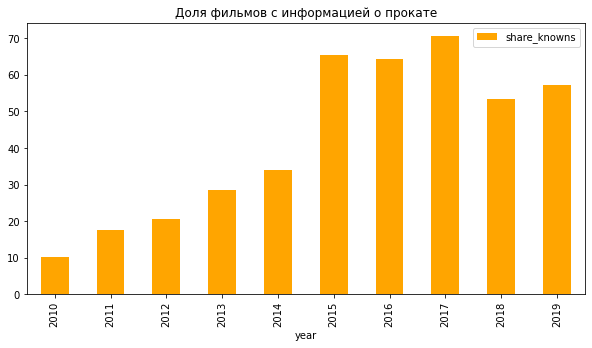

In [56]:
k.plot(kind='bar', y='share_knowns', title='Доля фильмов с информацией о прокате', color = 'orange', figsize =(10, 5))

На диаграмме видно, что менее всего данных о результатах проката в 2010 году (10.3 %). С этого периода их доля растет постепенно (от 7 до 15 процентов в год) до 2014 года включительно (34 %). Начиная с 2015 и до 2019 года доля фильмов, о которых известны результаты проката резко растет. Наиболее полно представлены данные о результатах проката фильмов в 2015 - 2017 годах. В этот период имеются сведения о 65-70% фильмов. Низкая доля информации о прокате фильмов в 2010-2014 годах может быть связана с недостаточностью информационно-телекоммуникационных технологий для такого учета в указанный период.

Также на стоолбчатой диаграмме пожно посмотреть распределение данных о прокате фильмов в кинотеатрах по годам в абсолютном выражении.

<AxesSubplot:title={'center':'Прокаты по годам'}, xlabel='year'>

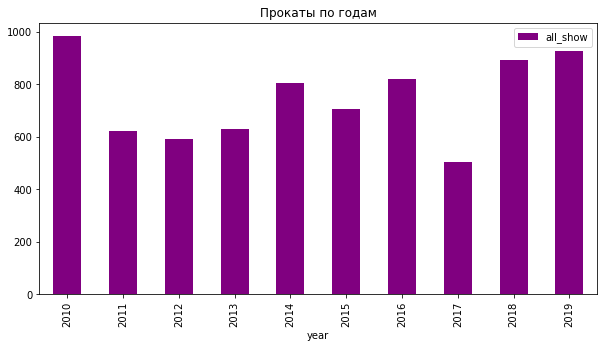

In [57]:
k.plot(kind='bar', y='all_show', title='Прокаты по годам', color = 'purple', figsize =(10, 5))

 На диаграмме и из таблицы видно, что в исследуемый период (с 2010 по 2019 годы) динамика проката не была ровной. Наибольшее количество прокатных удостоверений выдано в 2010 (985) и 2019 (930) годах. В период с 2011 по 2013 годы включительно отмечается резкий (почти на 30%) спад прокатов. Однако минимальное их число (505) отмечено в 2017 году.
 
 Чтобы узнать сумму сборов от проката фильмов за каждый год, а также программым методом вывести минимальную и максимальную сумму сборов, методом pivot_table создадим датафрейм, в котором в качестве индекса возьмем данные из столбца 'year', сгруппируем их по данным столбца 'box_office', к которому применим агрегирующий метод 'sum'.

,box_office
year,
2010,2.428654e+06
2011,1.410276e+07
2012,6.955423e+06
2013,2.979970e+07
2014,7.444952e+09
2015,3.949737e+10
2016,4.786630e+10
2017,4.363654e+10
2018,4.524917e+10


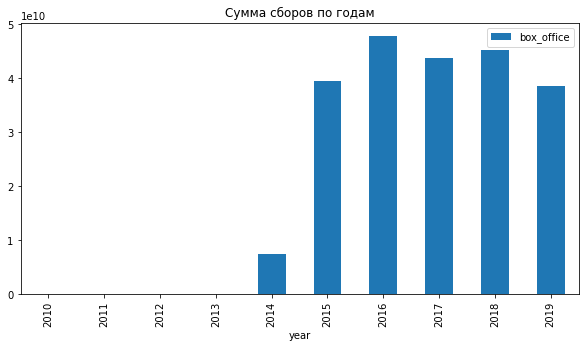

In [58]:
data.pivot_table(index='year' , values='box_office', aggfunc='sum'
                ).plot(kind='bar',  y='box_office', title='Сумма сборов по годам', figsize =(10, 5))
data.pivot_table(index='year' , values='box_office', aggfunc='sum')

Методом query(), примененным к датафрейму, находим годы с минимальной и максимальной суммой сборов от проката фильмов.

In [59]:
data.pivot_table(index='year' , values='box_office', aggfunc='sum').query('box_office == box_office.min()') 

,box_office
year,
2010,2428654.0


In [60]:
data.pivot_table(index='year' , values='box_office', aggfunc='sum').query('box_office == box_office.max()')

,box_office
year,
2016,4.786630e+10


Самые большие сборы от прокатов фильмов были в 2018 году и составили более 49 млрд.руб. (49668402949 руб.). Самую маленькую сумму собрали в 2010 году - 2.4 млн.руб.(2428654). Вместе с тем, к данной статистике необходимо относиться критически (в том числе с учетом небольшой разницы в количестве прокатов), поскольку ежегодно инфляция в России имела положительную динамику и стоимость билетов в кино за период с 2010 по 2018 годы только возрастала. Кроме того, как мы уже отметили, в 2010 году минимальное количество информации о результатах проката фильмов.

Нам необходимо с помощью сводной таблицы посчитать среднюю и медианную сумму сборов за каждый год. Для этой цели мы также применим метод pivot_table, где в качестве индекса передадим параметр 'year', проведем группировку по столбцу 'box_office', в качестве агрегирующих методов укажем 'mean' и 'median'. Поскольку медиана не применяется к нулевым значениям, до группировки проведем выборку даннх по столбцу 'box_office' с условием, что данные этого столбца != 0. Сводную таблицу сохраним в переменной g, в которой переименуем столбцы в соответствии с новыми значениями.

In [61]:
g = data.query('box_office != 0').pivot_table(index='year', values='box_office', aggfunc=['mean','median'])
g.columns = ['box_office_mean', 'box_office_median']
g['box_office_mean'] = g['box_office_mean'].astype(int)
g['box_office_median'] = g['box_office_median'].astype(int)
print(g)

      box_office_mean  box_office_median
year                                    
2010            24046               1710
2011           129383               3000
2012            56548               6220
2013           166478               3580
2014         27270885              20400
2015         85492132            5003449
2016         91173903            3915041
2017        122231197            9919415
2018         95261400            8751895
2019         72604827            4547560


<AxesSubplot:title={'center':'Сумма прокатов - средняя, медианная'}, xlabel='year'>

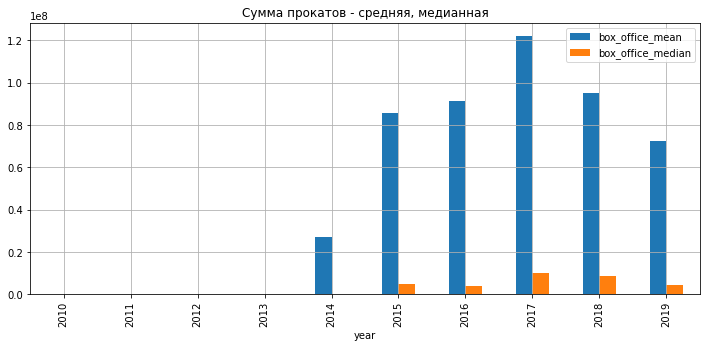

In [62]:
g.plot(grid=True, kind='bar', title='Сумма прокатов - средняя, медианная', figsize=(12, 5)) 

Из таблицы и на диаграмме видно, средняя сумма сборов по каждому году значительно превышает медианную.

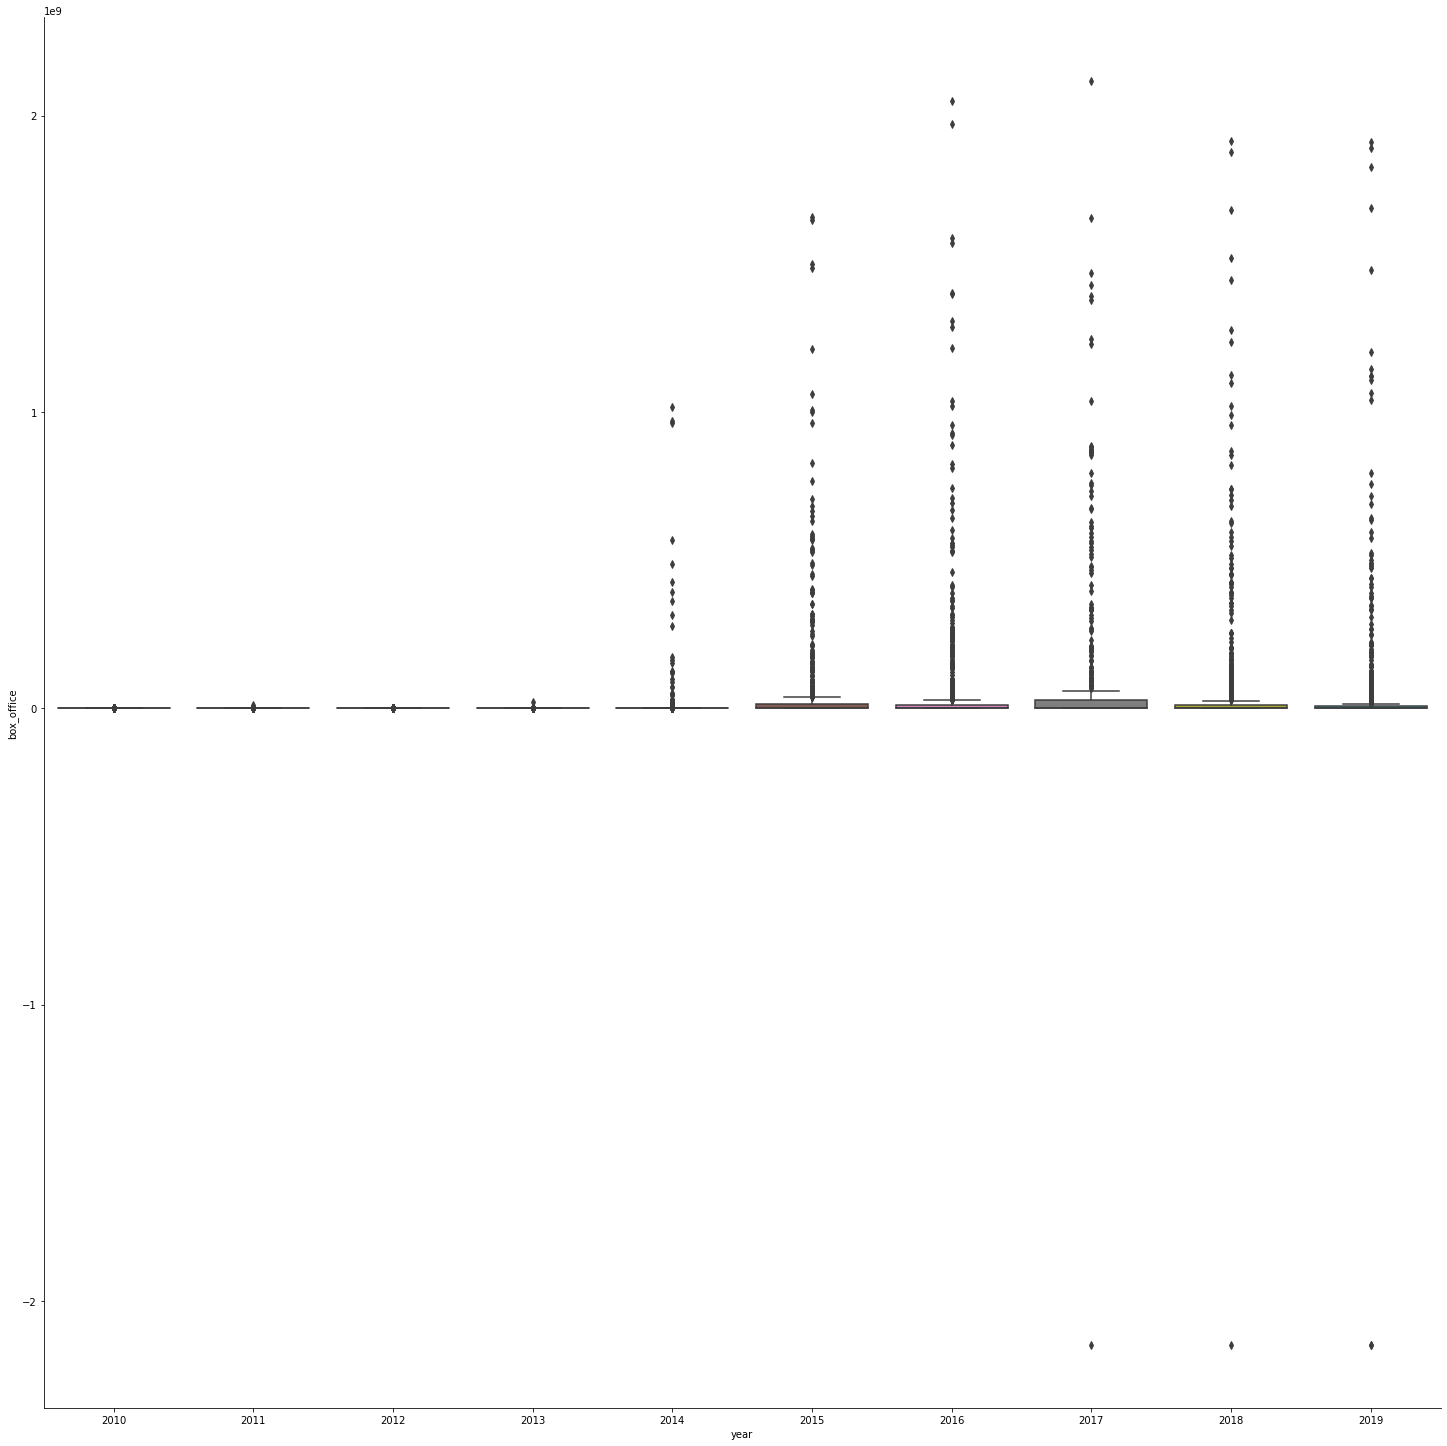

In [63]:
import seaborn as sns
ax = sns.catplot(x='year', y='box_office', data=data, kind="box", height=20)

У нас получились "ящики с усами" по параметру 'box_office' по годам. На этой разновидности графика видно, что в 'box_office' есть значения, сильно выбивающиеся за пределы межквартильного размаха, так называемые выбросы. При наличии таких выбросов среднее арифметическое значение (искомое в программировании функцией mean()) будет "сдвигаться" к большему значению, а медианное значение остановится ровно на половинном значении ото всех исследуемх данных. Цифровые показатели, согласно которым минимальная сумма сборов составила чуть более 2.4 млн. руб., максимальная - более 49 млрд.руб. также подтвердили значительный разброс сопоставляемых данных. Вот почему медианные суммы сборов от прокатов фильмов значительно меньше средних.

Для исследования влияния возрастного ограничения на сборы от фильмов в прокате мы создадим отдельный столбец, в котором данные о возрасте будут представлены по категориям, применим группировку исследуемых данных, построим диаграммы.

В столбце 'age_restriction' указана возрастная категория с расшифровкой. Для наглядности результатов анализа создадим функцию, которая будет возвращать данные о возрастной категории в более удобном для восприятия виде.

In [64]:
def age_group(age_restriction):
    if age_restriction == '«0+» - для любой зрительской аудитории':
        return '«0+»'
    if age_restriction == '«12+» - для детей старше 12 лет': 
        return '«12+»'
    if age_restriction == '«16+» - для детей старше 16 лет':
        return '«16+»'
    if  age_restriction == '«18+» - запрещено для детей': 
        return '«18+»'
    if age_restriction == '«6+» - для детей старше 6 лет':
        return '«6+»'
data['age_restriction'] = data['age_restriction'].apply(age_group)
data['age_restriction'].value_counts()

«16+»    2851
«18+»    1605
«12+»    1592
«0+»      811
«6+»      626
Name: age_restriction, dtype: int64

Чтобы выяснить наличие или отсутствие зависимости суммы сборов фильмов в прокате от возрастного ограничения в период с 2015 по 2019 годы, посредством метода query() создадим отдельный датафрейм, в котором зададим условием установленные временные рамки '2015 <= year <= 2019', методом pivot_table произведем группировку, где в качестве индекса возьмем данные столбца 'age_restriction', по которым сгруппируем прокатные сборы (столбец 'box_office'). В качестве агрегирующей функции зададим 'sum'.

In [65]:
w = data.query('2015 <= year <= 2019').pivot_table(index='age_restriction', values='box_office', aggfunc='sum')                                                
print(w)

                   box_office
age_restriction              
«0+»             8.090774e+08
«12+»            5.097916e+10
«16+»            7.131064e+10
«18+»            4.075962e+10
«6+»             5.087144e+10


Для наглядности результатов группировки составим столбчатую диаграмму и сделаем выборку самых больших сборов в исследуемый период прменив метод query() к уже новому датафрейму.

,box_office
age_restriction,
«16+»,7.131064e+10


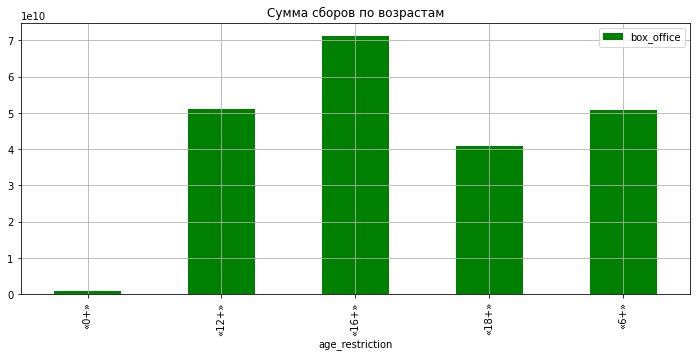

In [66]:
w.plot(grid=True, kind='bar', title='Сумма сборов по возрастам', color = 'green', figsize=(12, 5))
w.query('box_office == box_office.max()')

На диаграмме видно, что за весь период самые большие (более 76 млрд.руб.) сборы от проката фильмов, ориентированных на возрастную категорию «16+». Этот же вывод подтвержден и программной выборкой.

Для того, чтоб посмотреть на динамику сборов от фильмов в зависимости от возрастной аудитории по годам также составим таблицу методом pivot_table(), где в качестве индекса зададим два параметра 'year' и'age_restriction' и построим столбчатую диаграмму.

<AxesSubplot:title={'center':'Сборы от прокатов по возрасту по годам'}, xlabel='year,age_restriction'>

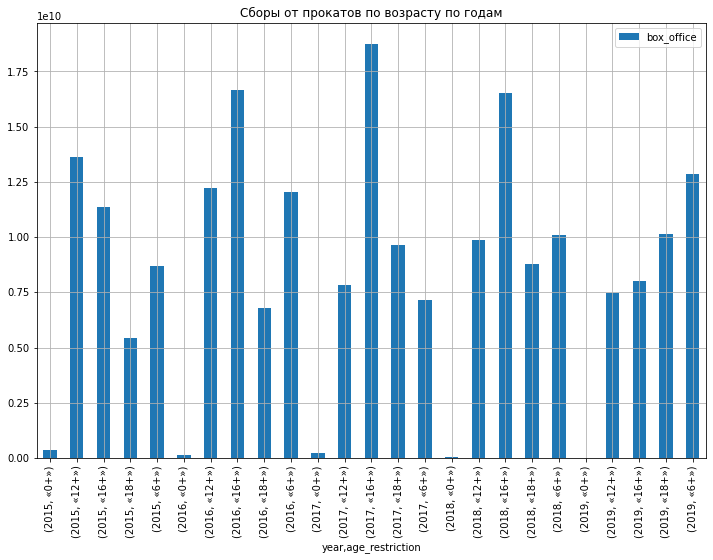

In [67]:
e = data.query('2015 <= year <= 2019').pivot_table(index=['year','age_restriction'], values='box_office', aggfunc='sum')
e.plot(grid=True, kind='bar', title='Сборы от прокатов по возрасту по годам', figsize=(12, 8))

Теперь при помощи метода query() сделаем выборку максимальных сборов от проката фильмов по годам и посмотрим как менялись возрастные группы, на которые ориентированы эти фильмы.

In [68]:
display(e.query('year == 2015').query('box_office == box_office.max()'))
display(e.query('year == 2016').query('box_office == box_office.max()'))
display(e.query('year == 2017').query('box_office == box_office.max()'))
display(e.query('year == 2018').query('box_office == box_office.max()'))
display(e.query('year == 2019').query('box_office == box_office.max()'))

,,box_office
year,age_restriction,
2015,«12+»,1.361608e+10


,,box_office
year,age_restriction,
2016,«16+»,1.666455e+10


,,box_office
year,age_restriction,
2017,«16+»,1.874504e+10


,,box_office
year,age_restriction,
2018,«16+»,1.650360e+10


,,box_office
year,age_restriction,
2019,«6+»,1.285255e+10


Из таблицы и на диаграмме видно, как менялись сборы от проката фильмов, ориентированных на различные возрастные категории, в течение 2015-2019 годов. В 2015 году максимальное количество сборов получили фильмы категории «12+». В период с 2016-2018 год наибольшие сборы у фильмов «16+». В 2019 году максимальное количество сборов принесли фильмы «6+». Однако, разница в этот год между фильмами этой возрастной категории, «12+» и «16+» незначительная. Теперь посмотрим как менялось по годам менялось количество прокатов фильмов разных возрастных категорий. Для этого также составим таблицу pivot_table() с этими же аргументами по индексу, но агрегирующей функцией count(), и диаграмму.

punumber
year age_restriction          
2015 «0+»                   50
     «12+»                 137
     «16+»                 249
     «18+»                 192
     «6+»                   77
2016 «0+»                   73
     «12+»                 136
     «16+»                 269
     «18+»                 245
     «6+»                   95
2017 «0+»                   44
     «12+»                  70
     «16+»                 153
     «18+»                 172
     «6+»                   66
2018 «0+»                   77
     «12+»                 243
     «16+»                 235
     «18+»                 222
     «6+»                  114
2019 «0+»                   71
     «12+»                 203
     «16+»                 266
     «18+»                 255
     «6+»                  133

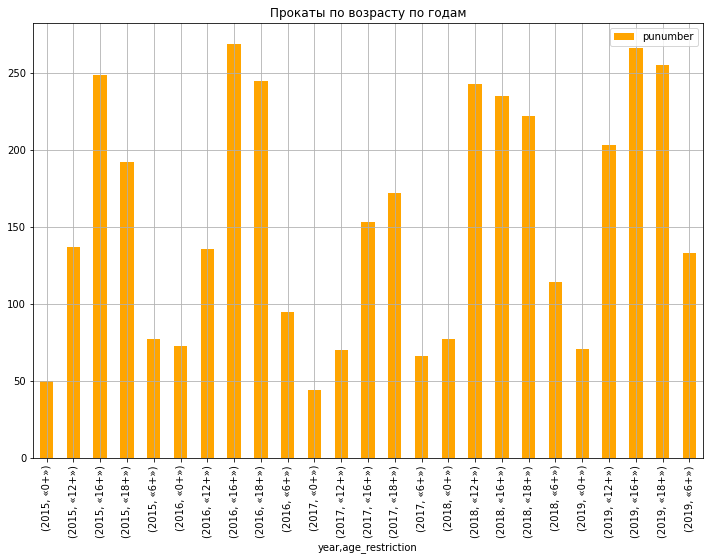

In [69]:
data.query('2015 <= year <= 2019').pivot_table(index=['year','age_restriction'], values='punumber', aggfunc='count'
                                              ).plot(grid=True, kind='bar', title='Прокаты по возрасту по годам', color = 'orange', figsize=(12, 8))
data.query('2015 <= year <= 2019').pivot_table(index=['year','age_restriction'], values='punumber', aggfunc='count')

Как видно из таблицы и диаграммы, максимальное количество прокатов по годам и возрастным категориям совпадает с максимальным количеством сборов по этим же параметрам только в 2016 году. Такую нелогичну динамику можно связать с отсутствием информации о сборах по всем фильмам.

### Вывод:

В исследуемый период (с 2010 по 2019 годы) динамика проката не была ровной. Наибольшее количество прокатных удостоверений выдано в 2010 (985) и 2019 (930) годах. В период с 2011 по 2013 годы включительно отмечается резкий (почти на 30%) спад прокатов. Однако минимальное их число (505) отмечено в 2017 году.

Доля фильмов, по которым имеется информация о результатах проката от общего количества фильмов, получивших прокатные удостоверения, составляет 41.9 %. Менее всего данных в 2010 году (10.3 %). С этого периода их доля растет постепенно (от 7 до 15 процентов в год) до 2014 года включительно (34 %).Низкая доля информации в указанный период может быть связана с недостаточностью информационно-телекоммуникационных технологий для такого учета в этот период. Начиная с 2015 и до 2019 года доля фильмов, о которых известны результаты проката резко растет. Наиболее полно (65-70% фильмов) представлены данные о результатах проката в 2015 - 2017 годах.

Самые большие сборы от прокатов фильмов были в 2018 году и составили более 49 млрд.руб. (49668402949 руб.). Самую маленькую сумму собрали в 2010 году - 2.4 млн.руб.(2428654). Вместе с тем, к данной статистике необходимо относиться критически (в том числе с учетом небольшой разницы в количестве прокатов), поскольку ежегодно инфляция в России имела положительную динамику и стоимость билетов в кино за период с 2010 по 2018 годы только возрастала. Кроме того, как мы уже отметили, в 2010 году минимальное количество информации о результатах проката фильмов.

Более других возрастных категорий составили сборы от проката фильмов, ориентированных на «16+» (более 76 млрд.руб.). В 2015 году максимальное количество сборов получили фильмы категории «12+». В период с 2016-2018 год наибольшие сборы у фильмов «16+». В 2019 году максимальное количество сборов принесли фильмы «6+». Однако, разница в этот год между фильмами этой возрастной категории, «12+» и «16+» незначительная. Вместе с тем, максимальное количество прокатов по годам и возрастным категориям совпадает с максимальным количеством сборов по этим же параметрам только в 2016 году. Такую нелогичную динамику можно связать с отсутствием информации о сборах по всем фильмам.

### Шаг 4. Исследование фильмов с государственной поддержкой


В ходе предобработки данных значения столбца 'ratings' мы привели к "единому знаменателю". Вместе с тем, для наглядности анализа мы их категоризируем, создав специальную функцию и добавив в исходный датафрейм новый столбец 'ratings_group'.


Для исследования фильмов, получивших государственную поддержку, мы соддадим отдельный датафрейм с новыми столбцами, категоризируем данные столбца 'ratings', проведем группировку данных, построим диаграммы, отдельно исследуем фильмы, окупившие себя.

In [70]:
def ratings_group(ratings):
    if ratings <= 9:
        return '0'
    if 10 <= ratings <= 19: 
        return '1'
    if 20 <= ratings <= 29:
        return '2'
    if  30 <= ratings <= 39:
        return '3'
    if 40 <= ratings <= 49:
        return '4'
    if 50 <= ratings <= 59:
        return '5'
    if 60 <= ratings <= 69:
        return '6'
    if 70 <= ratings <= 79:
        return '7'
    if 80 <= ratings <= 89:
        return '8'
    else:
        return '9'    
data['ratings_group'] = data['ratings'].apply(ratings_group)
data.groupby('ratings_group')['year'] .count()

ratings_group
0     995
1      19
2      36
3     123
4     400
5    1182
6    2406
7    1932
8     388
9       4
Name: year, dtype: int64

Для исследования фильмов, получивших государственную поддержку создадим отдельный датафрейм. В исходных данных в столбце 'financing_source' были пропущенные значения, которые равнялись количеству пропущенных значений в столбцах 'refundable_support', 'nonrefundable_support' и 'budget', из чего мы сделали вывод о том, что отсутствие информации в столбце свидетельствует об отсутствии государственной поддержки и заменили отсутствующие значения на 'unknown'. По этому датафрейм с фильмами, получившими господрержку, создадим путем применения метода query() к исходному датафрейму, задав условие financing_source != "unknown". Назовем датафрейм state_support и выведем его на экран.

In [71]:
state_support = data.query('financing_source != "unknown"').reset_index(drop=True)
state_support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  332 non-null    object        
 1   punumber               332 non-null    float64       
 2   show_start_date        332 non-null    datetime64[ns]
 3   type                   332 non-null    object        
 4   film_studio            332 non-null    object        
 5   production_country     332 non-null    object        
 6   director               332 non-null    object        
 7   producer               330 non-null    object        
 8   age_restriction        332 non-null    object        
 9   refundable_support     332 non-null    int32         
 10  nonrefundable_support  332 non-null    int32         
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  ratin

Как видно из информации в датафрейме 332 фильма, получившие государственную поддержку. Пропущенные значения только по столбцу 'producer', которые мы можем оставить в исходном состоянии, как не имеющие значения для анализа. В столбце 'budget' значения типа 'float' для единообразия данных о суммах переведем в цельночисленный тип.

In [72]:
state_support['budget'] = state_support['budget'].astype('int')

Изучим каков рейтинг у кинофильмов, имеющих государственную поддержку и не имеющих таковой. Для этого посчитаем средний рейтинг фильмов в датфрейме state_support и в фильмах исходного датафрейма data, задав условие financing_source == "unknown". Также из рассчетов исключим фильмы, где мы заменяли пропуски нулевыми значениями. В исходном датафрейме нулевых рейтингов не было. Подсчет рейтинга с их учетом может сильно "разбавить" и сделать некорректными показатели. Результаты выведем на экран.

In [73]:
print('Средний рейтинг фильмов, имеющих государственную поддержку, составляет', round((state_support.query('ratings != 0')['ratings'].mean()),1),'%.')


Средний рейтинг фильмов, имеющих государственную поддержку, составляет 60.0 %.


In [74]:
print('Средний рейтинг фильмов, не имеющих государственной поддержки, составляет',round((data.query('ratings != 0 and financing_source == "unknown"')['ratings'].mean()),1),'%.')

Средний рейтинг фильмов, не имеющих государственной поддержки, составляет 65.0 %.


Средний рейтинг фильмов, имеющих государственную поддержку (60.%), на 5% ниже, чем у фильмов, не поддержанных фмнансово государcтвом (65.0 %). Теперь посмотрим соотношение: всегда ли высокие рейтинги фильма влекут высокие сборы от их проката. Для этого методом pivot_table() сгруппируем данные по новому столбцу 'ratings_group' и средней суммой сборов от фильма и построим столбчатую диаграмму.

,box_office
ratings_group,
0,8.238249e+07
1,7.323648e+06
2,1.144404e+08
3,5.215211e+07
4,8.094337e+07
5,8.293323e+07
6,8.011813e+07
7,9.043035e+07
8,1.478612e+08


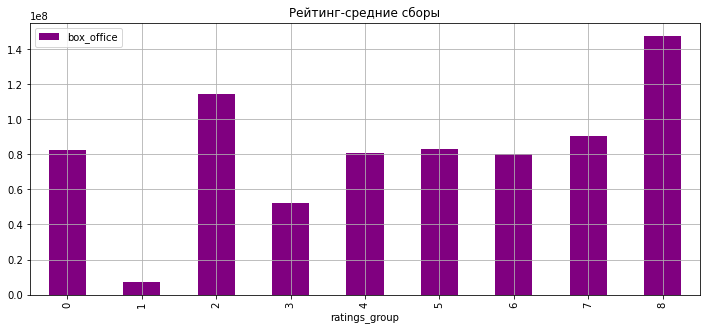

In [75]:
state_support.pivot_table(index='ratings_group', values='box_office', aggfunc='mean').plot(grid=True, kind='bar', title='Рейтинг-средние сборы', color = 'purple', figsize=(12, 5))
state_support.pivot_table(index='ratings_group', values='box_office', aggfunc='mean')

Найдем фильмы с господдержкой, имеющие самые высокие и самые низкие рейтинги.

In [76]:
state_support.query('ratings == ratings.max()')

,title,punumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,genres_n,director_n,ratings_group
6,А зори здесь тихие..._,111002915.0,2015-03-16 12:00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,Р.Давлетьяров,NaN,«12+»,50000000,100000000,220588394,Фонд кино,85,"драма,военный,история",249166767,2015,драма,Р.Давлетьяров,8
167,БОЛЬШОЙ,111017416.0,2016-11-22 12:00:00,Художественный,"ЗАО ""ПРОДЮСЕРСКАЯ КОМПАНИЯ ВАЛЕРИЯ ТОДОРОВСКОГО""",Россия,В.Тодоровский,"В.Тодоровский, А.Златопольский",«12+»,10000000,200000000,320000000,Фонд кино,85,"криминал,комедия,боевик",228578204,2016,криминал,В.Тодоровский,8


In [77]:
rm = state_support.query('ratings !=0')
rm.query('ratings == ratings.min()')

,title,punumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,genres_n,director_n,ratings_group
157,Взломать блогеров,111016616.0,2016-10-28 12:00:00,Художественный,"ООО ""ТаББаК""",Россия,М.Свешников,Т.Бекмамбетов,«6+»,0,25000000,36016269,Фонд кино,10,"комедия,мультфильм,фантастика",7323648,2016,комедия,М.Свешников,1


Из числа фильмов, снятых при финансовой поддержке государства, самые высокие рейтинги (по 85%) у фильма Р.Давлетьярова "А зори здесь тихие...", вышедшего в прокат в 2015 году и фильма В.Тодоровского "БОЛЬШОЙ", увидившего свет в 2016 году. Самый низкий рейтинг (10%) у фильма М.Свешникова "Взломать блогеров", который вышел в прокат в 2016 году. Вместе с тем, как видно, не всегда высокие рейтинги фильфов свидетельствют о высоких сборах от их прокатов. Минимальные средние сборы у фильмов с минимальным рейтингом. Здесь это соотношение выполнено. Но у фильмов с рейтингом от 20-29% (по нашей категории - 2) средние сборы значительно (в два раза) выше, чем у фильмов с рейтингами 30-59%. (по нашей шкале категории 3, 4, 5). Максимальные средние сборы у фильмов с рейтингом 70-79% (категория 7). У фильмов с категориями 6 и 8 (рейтинги 60-69% и 80-89% соответственно) средние сборы на четверть ниже максимальных. Примечательно, что среди фильмов, поддержанных государством нет тех, чьи рейтинги более 90%.

Теперь проанализируем на какую возрастную категорию ориентированы фильмы, поддержанные государством. Для этого сгруппируем данные по столбцу 'age_restriction' методом groupby() и построим столбчатую диаграмму.

age_restriction
«0+»       8
«12+»    106
«16+»    125
«18+»     28
«6+»      65
Name: age_restriction, dtype: int64

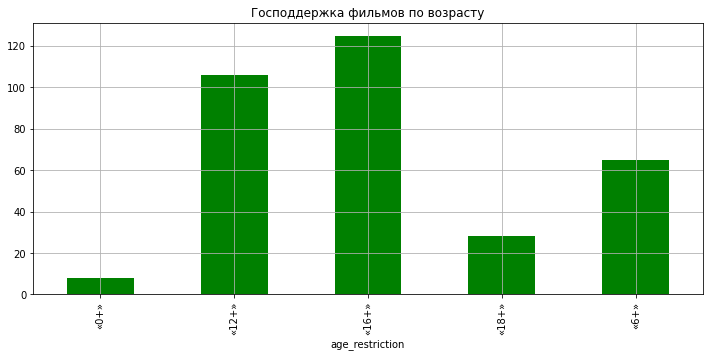

In [78]:
state_support.groupby('age_restriction')['age_restriction'].count().plot(
    grid=True, kind='bar', title='Господдержка фильмов по возрасту', color = 'green', figsize=(12, 5))
state_support.groupby('age_restriction')['age_restriction'].count()


Государством, в основном, поддерживаются фильмы, ориентированные на возрастные категории «12+» и «16+», для которых выпустили 106 и 125 фильмов соответственно, что составляет около 70%. Теперь посмотрим какими жанрами представлены фильмы, поддержанные государством. Для этого сгруппируем данные по столбцу 'genres_n', построим диаграмму и выведем цифровые показатели методом value_counts(). Также определим приоритеты по типу фильмов, применив метод value_counts() к столбцу 'type'.

драма          93
комедия        74
мультфильм     31
unknown        16
триллер        15
мелодрама      15
фэнтези        11
фантастика     11
ужасы          10
военный         9
приключения     7
семейный        7
боевик          6
детектив        5
мюзикл          4
история         4
детский         4
криминал        3
спорт           3
биография       3
реальное ТВ     1
Name: genres_n, dtype: int64

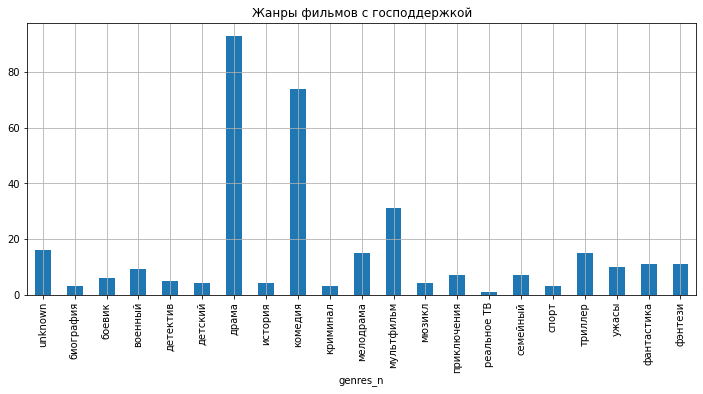

In [79]:
state_support.groupby('genres_n')['year'].count().plot(
    grid=True, kind='bar', title='Жанры фильмов с господдержкой', figsize=(12, 5))
state_support['genres_n'].value_counts()

In [80]:
state_support['type'].value_counts()

Художественный    300
Анимационный       31
Документальный      1
Name: type, dtype: int64

Таблица свидетельствует, что жанр большинства фильмов, поддержанных государством, относится к драме (93), чуть менее (74) - комедии, на третьем месте (31) - мульфильмы. Все остальные жанры представлены менее 10% каждый. Эта же тенденция видна и на диаграмме. По типу подавляющее большинство фильмов (300) являются художественными картинами, 31 картина анимационная и в единственном числе представлена документальная лента.

Теперь исследуем окупаемость фильмов с господдержкой, исходя из того, что фильм считается окупившим себя, когда кассовые сборы как минимум превышают бюджет фильма. Для этого создадим в state_support два дополнительных столбца с информацией о доле государственной поддержки по каждому фильму (разделив сумму данных столбцов по возвратным и невозвратным средствам на данные столбца о бюджете при условии budget != 0) и об окупаемости фильмов (разделив данные столбца 'box_office' на 'budget', также при условии budget != 0. Новые столбцы назовем 'share_state_support' и 'payback' соответственно.

In [81]:
state_support['share_state_support'] = round((state_support['refundable_support'] + state_support['nonrefundable_support']
                                             )/state_support.query('budget != 0')['budget']*100)
state_support['payback'] = round(state_support['box_office']/state_support.query('budget != 0')['budget']*100)
state_support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  332 non-null    object        
 1   punumber               332 non-null    float64       
 2   show_start_date        332 non-null    datetime64[ns]
 3   type                   332 non-null    object        
 4   film_studio            332 non-null    object        
 5   production_country     332 non-null    object        
 6   director               332 non-null    object        
 7   producer               330 non-null    object        
 8   age_restriction        332 non-null    object        
 9   refundable_support     332 non-null    int32         
 10  nonrefundable_support  332 non-null    int32         
 11  budget                 332 non-null    int32         
 12  financing_source       332 non-null    object        
 13  ratin

Для начала посчитаем окупаемость фильмов с господдержкой в целом путем деления суммы сборов от всех фильмов рассматриваемой категории ('box_office') на сумму их бюджетов ('budget', также с условием budget != 0), умножим на 100 и получим окупаемость в процентах.

In [82]:
state_support = state_support.query('budget != 0')
print('Окупаемость фильмов, получивших государственную поддержку, составляет', round(state_support['box_office'].sum(
)/state_support['budget'].sum()*100),'%.')

Окупаемость фильмов, получивших государственную поддержку, составляет 66 %.


Как свидетельствует статистика, фильмы, получающие государственную поддердку, себя не окупают. По всей видимости в этом и состоит смысл государственной поддержки фильмов заведомо слабо окупаемых, которые не преследуют своей целью извлечение прибыли, а создаются в просветительских, воспитательных и иных целях государственной политики в области культуры и искусства. Интересно в этой связи исследовать взаимозависимость таких параметров как бюджет фильма рассматриваемой категории, кассовые сборы, окупаемость, долю государственной поддержки и рейтинг. Для этого проведем декомпозицию state_support и построим попарную диаграмму методом pd.plotting.scatter_matrix() и выведем проценты корреляции.

In [83]:
ds = state_support[['box_office', 'ratings', 'payback', 'share_state_support', 'budget']]
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 331
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   box_office           315 non-null    int32  
 1   ratings              315 non-null    int32  
 2   payback              315 non-null    float64
 3   share_state_support  315 non-null    float64
 4   budget               315 non-null    int32  
dtypes: float64(2), int32(3)
memory usage: 11.1 KB


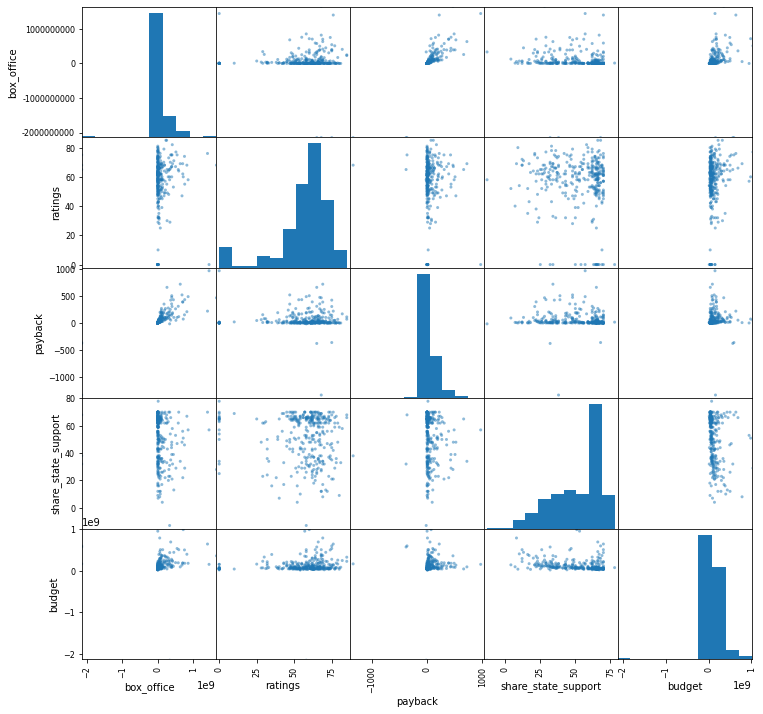

In [85]:
ax = pd.plotting.scatter_matrix(ds,figsize=(12, 12))

In [86]:
print(ds['box_office'].corr(ds['ratings']))
print(ds['box_office'].corr(ds['budget']))
print(ds['box_office'].corr(ds['payback']))
print(ds['ratings'].corr(ds['payback']))
print(ds['ratings'].corr(ds['share_state_support']))
print(ds['box_office'].corr(ds['share_state_support']))
print(ds['payback'].corr(ds['share_state_support']))

0.017655411800794236
0.09839235107276617
0.7882649802980329
-0.007207543936162356
-0.08373314969930362
-0.07896575127152718
-0.05405553687900064


Имеется довольно заметная положительная корреляция между бюджетом фильма и кассовыми сборами - чем выше бюджет фильма, тем больше сборы. Такая же логичная динамика между сборами и окупаемостью. Между кассовыми сборами, окупаемостью и рейтингом фильмов зависимости практически нет. Фильмы с высокими рейтингами могут иметь как высокие так и низкие сборы и окупаемость, а вот фильмы с низкими рейтингами, как правило имеют и низкие кассовые сборы и, соответственно, окупаемость. Доля государствнной поддержки также мало связана с рейтингами фильмов и их окупаемостью.

 Теперь посчитаем количество фильмов, поддержанных государством, которые себя окупили. Для этого создадим отдельный датафрейм с помощью метода query() с условием budget < box_office. Назовем датафрейм с окупаемостью payback_movie.

In [87]:
payback_movie = state_support.query('budget < box_office').reset_index(drop=True)
print('Количество окупивших себя фильмов c государственной поддержкой составляет',len(payback_movie),'.')
print('Сборы у этих фильмов превысили бюджет в',round(payback_movie['box_office'].sum()/payback_movie['budget'].sum(),1),'раза.')

Количество окупивших себя фильмов c государственной поддержкой составляет 64 .
Сборы у этих фильмов превысили бюджет в 2.9 раза.


Теперь внимательнее изучим информацию об этих фильмах: в какие годы преимущественно состоялись премьеры этих фильмов, на какую возрастную аудиторию они рассчитаны, каковы основные тип и жанр этих фильмов. Для этого применим группировку данных по столбцам 'year', 'age_group', 'type','genres_n', построим диаграммы. Найдем фильмы с самым высоким и самым низким рейтигнами.

year
2014     3
2015    13
2016     9
2017    12
2018    16
2019    11
Name: year, dtype: int64

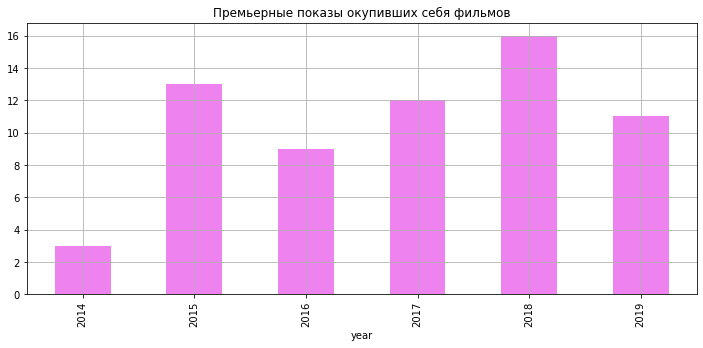

In [88]:
payback_movie.groupby('year')['year'].count().plot(
    grid=True, kind='bar', title='Премьерные показы окупивших себя фильмов', color = 'violet', figsize=(12, 5))
payback_movie.groupby('year')['year'].count()

age_restriction
«0+»      1
«12+»    25
«16+»    19
«18+»     2
«6+»     17
Name: type, dtype: int64

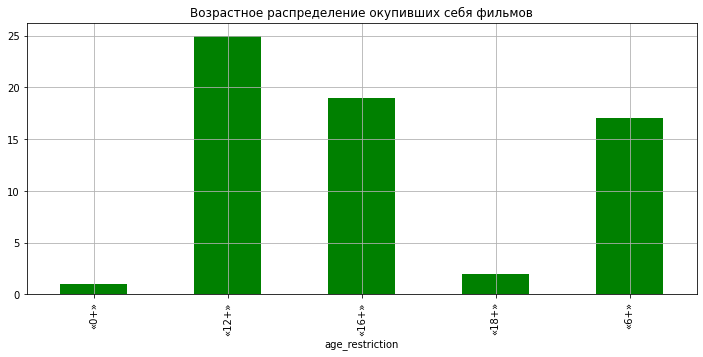

In [89]:
payback_movie.groupby('age_restriction')['type'].count().plot(
    grid=True, kind='bar', title='Возрастное распределение окупивших себя фильмов', color = 'green', figsize=(12, 5))
payback_movie.groupby('age_restriction')['type'].count()

In [90]:
payback_movie.groupby('type')['type'].count()

type
Анимационный       8
Художественный    56
Name: type, dtype: int64

Для наглядности распределения окупивших себя фильмов по возрасту с указанием типов в соответствии с рекомендацией построим гистограмму при помощи библиотеки seaborn по данным датафрейма payback_movie с параметрами "age_restriction" и "type".

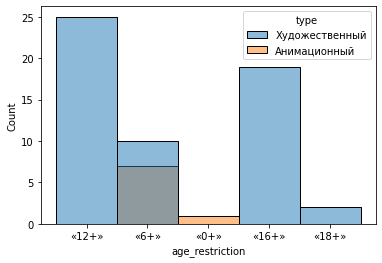

In [91]:
import seaborn as sns
sns_plot = sns.histplot(data = payback_movie,  x = "age_restriction", hue = "type")

На графике видно распределение окупивших себя фильмов фильмов по возрасту и типу. Анимационные фильмы снимаются для зрителей «0+» и «6+», художественные - для всех возрастов кроме «0+».

комедия        25
драма          12
мультфильм      8
семейный        3
ужасы           3
военный         3
приключения     2
биография       1
спорт           1
фэнтези         1
боевик          1
фантастика      1
unknown         1
триллер         1
история         1
Name: genres_n, dtype: int64

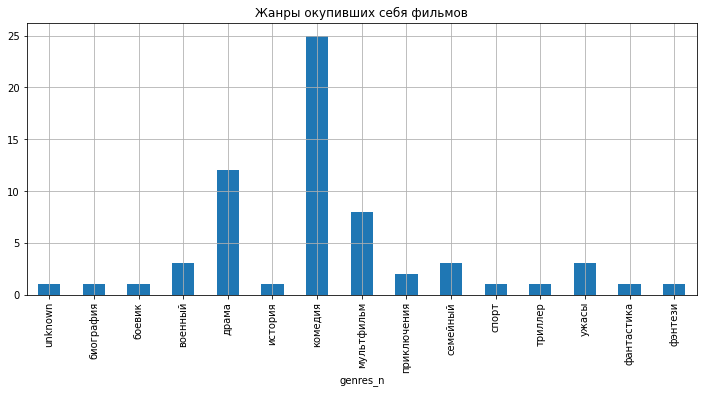

In [92]:
payback_movie.groupby('genres_n')['type'].count().plot(
    grid=True, kind='bar', title='Жанры окупивших себя фильмов', figsize=(12, 5))
payback_movie['genres_n'].value_counts()

In [93]:
payback_movie.query('ratings == ratings.max()')

,title,punumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,financing_source,ratings,genres,box_office,year,genres_n,director_n,ratings_group,share_state_support,payback
0,А зори здесь тихие..._,111002915.0,2015-03-16 12:00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,Р.Давлетьяров,NaN,«12+»,50000000,...,Фонд кино,85,"драма,военный,история",249166767,2015,драма,Р.Давлетьяров,8,68.0,113.0


In [94]:
rp = payback_movie.query('ratings != 0')
rp.query('ratings == ratings.min()')

,title,punumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,financing_source,ratings,genres,box_office,year,genres_n,director_n,ratings_group,share_state_support,payback
24,Крым (2017),111002017.0,2017-04-12 12:00:00,Художественный,"ООО ""Пиманов и партнеры""",Россия,А.Пиманов,А.Пиманов,«16+»,20000000,...,Фонд кино,29,"драма,боевик",342898736,2017,драма,А.Пиманов,2,23.0,154.0


Наибольшее количество фильмов, снятых при государственном финансировании и окупивших себя, вышли с премьерным показом в 2015, 2017-2018 годах. Большинство из них (27, или 40%) ориентированы на возрастную категорию "12+", чуть менее 30% рассчитаны на возраст "16+" и "6+" (19 и 17 соответственно), по типу подавляющее большинство этих фильмов (почти 90%) - художественные, остальные - анимационные.Такое распределение соответствует распределению по всем фильмам, поддержанным государством. А вот жанровое распределение окупивших себя фильмов иное по отношению к общему распределению. Если большинство фильмов с господдержкой являются драмой, то в числе окупивших себя лидирующее место (26 из 66, почти 40 %) занимают комедии. Драма окупает себя в два раза реже комедии (13 фильмов). Однако, самый высокий рейтинг среди окупивших себя фильмов вовсе не у комедии. Наибольшее количество зрительских симпатий опять собрала драма "А зори здесь тихие..". Самый низкий рейтинг тоже у драмы А.Пиманова, вышедшей в 2017 году "Крым (2017)".

### Вывод:

Государством, в основном, поддерживаются фильмы, ориентированные на возрастные категории «12+» и «16+», для которых выпустили 106 и 125 фильмов соответственно, что составляет около 70%. Жанр большинства фильмов, поддержанных государством, относится к драме (93), комедии (74), мульфильмам (31). Подавляющее большинство фильмов (300) являются художественными картинами, 31 картина анимационная. Средний рейтинг фильмов, имеющих государственную поддержку (60%), на 5 % ниже, чем у фильмов, не поддержанных фмнансово государcтвом (65%). Вместе с тем, не всегда высокие рейтинги фильфов свидетельствют о высоких сборах от их прокатов. Минимальные средние сборы у фильмов с минимальным рейтингом. Но у фильмов с рейтингом от 20-29% средние сборы значительно (в два раза) выше, чем у фильмов с рейтингами 30-59%. Максимальные средние сборы у фильмов с рейтингом 70-79% (категория 7). Примечательно, что среди фльмов, поддержанных государством нет таких, рейтинги которых превышали бы 90%.

Государством, в основном, поддерживаются фильмы, ориентированные на возрастные категории «12+» и «16+», для которых выпустили 106 и 125 фильмов соответственно, что составляет около 70%. Жанр большинства фильмов, поддержанных государством, относится к драме (93), комедии (74), мульфильмам (31). Подавляющее большинство фильмов (300) являются художественными картинами, 31 картина анимационная. Средний рейтинг фильмов, имеющих государственную поддержку (60%), на 5 % ниже, чем у фильмов, не поддержанных фмнансово государcтвом (65%). Вместе с тем, не всегда высокие рейтинги фильфов свидетельствют о высоких сборах от их прокатов. Минимальные средние сборы у фильмов с минимальным рейтингом. Но у фильмов с рейтингом от 20-29% средние сборы значительно (в два раза) выше, чем у фильмов с рейтингами 30-59%. Максимальные средние сборы у фильмов с рейтингом 70-79% (категория 7). Примечательно, что среди фльмов, поддержанных государством нет таких, рейтинги которых превышали бы 90%.

Наибольшее количество фильмов, снятых при государственном финансировании и окупивших себя, вышли с премьерным показом в 2015, 2017-2018 годах. Большинство из них (27, или 40%) ориентированы на возрастную категорию "12+", чуть менее 30% рассчитаны на возраст "16+" и "6+" (19 и 17 соответственно). По типу подавляющее большинство этих фильмов (почти 90%) - художественные, остальные - анимационные.Такое распределение соответствует распределению по всем фильмам, поддержанным государством. Жанровое распределение окупивших себя фильмов иное по отношению к общему распределению. Если большинство фильмов с господдержкой являются драмой, то в числе окупивших себя лидирующее место (26 из 66, почти 40 %) занимают комедии. Драма окупает себя в два раза реже комедии (13 фильмов). Однако, самый высокий рейтинг среди окупивших себя фильмов вовсе не у комедии. Наибольшее количество зрительских симпатий опять собрала драма "А зори здесь тихие..".

### Шаг 5. Напишите общий вывод

На основе открытых данных Министерства культуры, информации с сайта КиноПоиск мы исследовали рынок российского кинопроката, эффективность государственной поддержки фильмов, зрительский интерес.Для работы с данными мы объединили исходные датафреймы data_movies и data_shows по столбцу 'puNumber' (проведя его предварительную обработку). Новому датафрейму присвоили наименование data. Наименование столбца, по которому провели объединение, привели к общепринятому стилю. В ходе предобработки данных изменили их тип в столбцах 'refundable_support', 'nonrefundable_support', 'box_office', 'ratings' на цельночисленный, в столбце 'show_start_date' - на 'datetime64'. В столбцах 'financing_source', 'director' и 'genres' пропущенные значения заменили на 'unknown', в столбцах 'refundable_support', 'nonrefundable_support', 'box_office' и 'ratings'- на нулевые значения. Проверили наличие явных и неявных дубликатов. Ибавились от неявных дубликатов в столбце 'type', 'punumber'. Создали дополнительные столбцы с годом выхода в прокат фильма, жанром фильма, именем и фамилией главного режисера, долей государственной поддержки в общем бюджете фильма, окупаемостью. Категоризировали данные столбца 'ratings' и изменили наименованя значений столбца 'age_restriction'. В процессе анализа для максимального сохранения объема общего датафрейма исследование отдельных показателей осуществлялось по специально созданным датафреймам с приемлемыми условиями. Из общего датафрейма была удалена только 1 строка, что не отразилось на корректности данных.

В исследуемый период (с 2010 по 2019 годы) динамика проката не была ровной. Наибольшее количество прокатных удостоверений выдано в 2010 (985) и 2019 (930) годах. В период с 2011 по 2013 годы включительно отмечается резкий (почти на 30%) спад прокатов. Однако минимальное их число (505) отмечено в 2017 году. Доля фильмов, по которым имеется информация о результатах проката от общего количества фильмов, получивших прокатные удостоверения, составляет 41.9 %. Менее всего данных в 2010 году (10.3 %). Низкая доля информации в указанный период может быть связана с недостаточностью информационно-телекоммуникационных технологий для такого учета в этот период. Наиболее полно (65-70% фильмов) представлены данные о результатах проката в 2015 - 2017 годах.

Самые большие сборы от прокатов фильмов имели место в 2018 году и составили более 49 млрд.руб. (49668402949 руб.). Самую маленькую сумму собрали в 2010 году - 2.4 млн.руб.(2428654). Вместе с тем, к данной статистике необходимо относиться критически (в том числе с учетом небольшой разницы в количестве прокатов). Как мы уже отметили, в 2010 году минимальное количество информации о результатах проката фильмов. Кроме того, ежегодно инфляция в России имела положительную динамику и стоимость билетов в кино за период с 2010 по 2018 годы возрастала. Jбщая картина такова, что сборы от проката в 2016-2019 годах примерно одинаковы и составляют 48-49 млрд.руб.

Исследование влияния возрастного ограничения фильмов на сборы от проката в 2015-2019 годах показало, что самую большую сумму за весь период собрали фильмы «16+» (более 76 млрд.руб.). По годам сборы распредилились так, что в 2015 году максимальную сумму принесли фильмы «12+», в 2016-2018 годах - «16+», в 2019 году - «6+». Однако, разница в 2019 году между сборами от фильмов «6+», «12+» и «16+» незначительная. Вместе с тем, максимальное количество прокатов по годам и возрастным категориям совпадает с максимальным количеством сборов по этим же параметрам только в 2016 году. Такую нелогичную динамику можно связать с отсутствием информации о сборах по всем фильмам.

Средний рейтинг фильмов, имеющих государственную поддержку (60%), на 5 % ниже, чем у фильмов, не поддержанных фмнансово государcтвом (65%). Вместе с тем, не всегда высокие рейтинги фильфов свидетельствют о высоких сборах от их прокатов. Минимальные средние сборы у фильмов с минимальным рейтингом. Но у фильмов с рейтингом от 20-29% средние сборы значительно (в два раза) выше, чем у фильмов с рейтингами 30-59%. Максимальные средние сборы у фильмов с рейтингом 70-79%, а не с высшими рейтингами. Среди фильмов, поддержанных финансово государством нет с рейтингами 90% и выше.

Государством, в основном, поддерживаются художественные и анимационные фильмы, ориентированные на возрастные категории «12+» и «16+». Жанровое распределение - драмы (93), комедии (74), мультфильмы (31). Фильмы, получающие государственную поддержку, в целом, себя не окупают. Доля государствнной поддержки также мало связана с рейтингами фильмов и их окупаемостью. Имеется довольно заметная положительная корреляция между бюджетом фильма и кассовыми сборами - чем выше бюджет фильма, тем больше сборы. Такая же логичная динамика между сборами и окупаемостью. Между кассовыми сборами, окупаемостью ( с одной стороны) и рейтингом фильмов зависимости практически нет. Фильмы с высокими рейтингами могут иметь как высокие так и низкие сборы и окупаемость, а вот фильмы с низкими рейтингами, как правило имеют и низкие кассовые сборы и, соответственно, окупаемость. В этой связи стоит помнить, что смысл государственной поддержки фильмов состоит в "продвижении" лент, создаваемых в просветительских, воспитательных и иных целях государственной политики в области культуры и искусства, а не извлечении прибыли.

Наибольшее количество фильмов, снятых при государственном финансировании и окупивших себя, вышли с премьерным показом в 2015, 2017-2018 годах, в основном (70%), ориентированы на возраст "12+", "16+" и "6+", являются худолественными (почти 90%), либо анимационными. Такое распределение соответствует распределению по всем фильмам, поддержанным государством. А вот жанровое распределение окупивших себя фильмов иное. Если большинство фильмов с господдержкой являются драмой, то в числе окупивших себя лидирующее место (26 из 66, почти 40 %) занимают комедии. Драма окупает себя в два раза реже комедии (13 фильмов). Однако, самый высокий рейтинг среди окупивших себя фильмов вовсе не у комедии. Наибольшее количество зрительских симпатий опять собрала драма "А зори здесь тихие..".

В целом, современные тенденции кинопроката таковы, что динамика проката в последний год исследуемого периода вышла на уровень 2010, когда было самое большое количество прокатов. Сборы от прокатов фильмов, начиная с 2016 года примерно на одном уровне (48-49 млрд. руб.). Несмотря на тот факт, что за последние 5 исследуемых лет наибольшие сборы принесли фильмы "16+", в 2019 году они почти сравнялись с фильмами "12+" и "6+". Государственную поддержку получают, в основном художественные и анимационные фильмы, ориентированные на возрастные категории «12+» и «16+», относящиеся к жанрам драмы, комедии и мультфильмам. Фильмы, получающие государственную поддержку, в целом, себя не окупают. Средний рейтинг фильмов этой категории (60%) несколько ниже, чем у фильмов, не поддержанных государством (65%). Фильмы с господдержкой не получали рейтинги 90% и выше.Вместе с тем, сборы от фильмов не всегда связаны с их рейтингами. Максимальные средние сборы у фильмов с рейтингом 70-79%, а не с высшим. Среди фильмов, снятых при господдержке и окупивших себя распределение по возрасту и типу соответствует общему распределению фильмов, поддержанных государством. А вот жанровое распределение окупивших себя фильмов иное. Если большинство фильмов с господдержкой являются драмой, то в числе окупивших себя лидирующее место (26 из 66, почти 40 %) занимают комедии. Этот факт возможно принять во внимание при определении приоритетов для государственной поддержки кино и минимизации конфликта целей киноиндустрии (извлечение прибыли от кинопроката) и государственных целей (воспитание, просвещение) в области искусства и культуры.